# Before you get started

## Data formatting

Ensure that your expression data is of the form log2(TPM+1) or log2(FPKM+1)

miner will search for specific filenames in the miner/data folder. In order to avoid "File does not exist" errors, do the following:
    1. Name your expression data "expressionData.csv"
    2. Name your mutation data "mutations.csv" (only for causal analysis)
    3. Name your survival data "survival.csv" (only for survival analysis)
   
Note that the gene names will be converted to Ensembl Gene ID format

## Data location

This tutorial will import data stored in the "miner/data" folder. Before you start, move your data to the "miner/data" folder. 

## Special dependencies

These dependencies are not required for coexpression clustering or mechanistic inference, but are employed for optional functions in the miner library

Survival analysis:
    install lifelines

# Begin miner analysis

## Import standard dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import time
from collections import Counter
from sklearn.manifold import TSNE
import miner
%matplotlib inline

## Create directory to save output files

In [5811]:
# create name for results folder where output files will be saved
resultsFolder = "results_mmrf_optimization"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load input data into dataframe

In [5221]:
expressionData = pd.read_csv(os.path.join("..","data","IA12Zscore.csv"),index_col=0,header=0)
#expressionData = pd.read_table(os.path.join("..","data","single.cell.data.adrian.txt"),index_col=0,header=0)
#expressionData = pd.read_csv(os.path.join("..","data","gbmTCGA_exprMat_medianFiltered.csv"),index_col=0,header=0)

## Convert annotations (skip if samples are not Homo Sapiens)

In [5222]:
expressionData, conversionTable = miner.identifierConversion(expressionData)

completed identifier conversion.
16216 genes were converted.


## Pre-process expression data

In [5223]:
expressionData = miner.zscore(expressionData)

## Load previous results (skip if results have not previously been generated)

In [5508]:
# If previous results exist, use miner.read_json to load them
#revisedClusters = miner.read_json(os.path.join(resultsDirectory,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(resultsDirectory,"coexpressionModules.json"))
regulons = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(resultsDirectory,"mechanisticOutput.json"))

## Cluster expression data

In [5224]:
reload(miner)
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes=8,overExpressionThreshold=80)
# sort cluster list from largest to smallest
initialClusters.sort(key= lambda s: -len(s))
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))

0.00 percent complete
6.67 percent complete
13.33 percent complete
20.00 percent complete
26.67 percent complete
33.33 percent complete
40.00 percent complete
46.67 percent complete
53.33 percent complete
60.00 percent complete
66.67 percent complete
73.33 percent complete
80.00 percent complete
86.67 percent complete
93.33 percent complete

coexpression clustering completed in 16.96 minutes


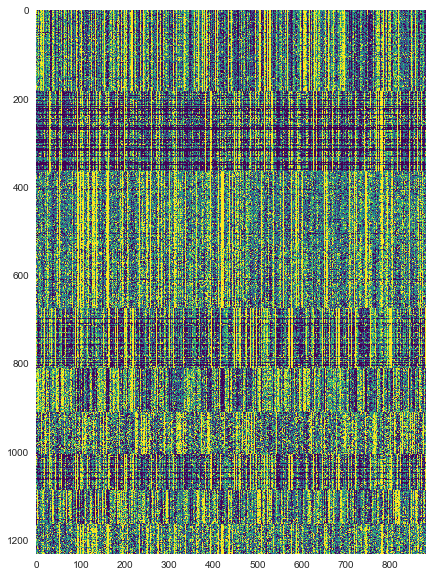

In [5705]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.grid(False)
plt.imshow(expressionData.loc[np.hstack([revisedClusters[i] for i in range(10)]),:],cmap="viridis",vmin=-1,vmax=1)

In [5227]:
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print(len(revisedClusters))

Number of genes clustered: 9106
669


## Infer coregulated modules (only supported for Homo Sapiens)

In [5927]:
reload(miner)
t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=0.2,dataFolder=os.path.join("..","data"))
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=5,freqThreshold = 0.333)
# write regulons to json file
miner.write_json(regulons,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))
#reconvert revised clusters
annotatedRevisedClusters = miner.convertDictionary(revisedClusters,conversionTable)
# write annotated coexpression clusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary_annotated.json"))
t2 = time.time()
print("completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))

0
133
134
267
1
135
268
136
138
269
401
137
402
270
271
139
403
535
2
536
272
537
404
140
538
405
273
406
539
141
407
540
408
274
541
409
142
542
543
275
410
544
143
276
411
144
545
277
412
546
3
145
413
278
146
547
548
414
147
279
415
549
280
148
416
281
417
550
149
282
551
283
418
150
419
4
284
552
151
420
152
285
5
421
553
153
286
287
422
154
554
288
423
289
424
555
155
425
556
290
557
156
291
426
427
292
558
428
157
6
429
293
559
430
560
294
158
295
561
431
432
159
296
433
562
7
297
160
434
563
161
8
435
298
564
565
436
299
162
566
437
300
567
163
438
301
9
568
164
302
439
569
303
570
165
166
440
304
571
305
10
167
572
441
306
573
442
168
307
443
574
308
575
444
169
11
445
576
170
309
446
577
171
310
578
447
579
172
311
448
173
12
580
449
312
174
450
581
175
451
313
176
452
582
13
314
583
177
453
454
315
584
455
456
178
316
457
585
14
179
458
317
180
586
459
318
181
587
319
15
588
182
460
320
589
183
590
461
184
16
321
591
462
592
593
185
463
322
594
17
595
596
464
186
323
597
598


In [5928]:
regulonModules, regulonDf = miner.regulonDictionary(regulons)
print(len(regulonModules))

2372


# Construction zone!

In [ ]:
def getRegulons(coregulationModules,minNumberGenes=5,freqThreshold = 0.333):

    regulons = {}
    keys = coregulationModules.keys()
    for i in range(len(keys)):
        tf = keys[i]
        normDf = coincidenceMatrix(coregulationModules,key=i,freqThreshold = 0.333)
        unmixed = unmix(normDf)   
        remixed = remix(normDf,unmixed)
        if len(remixed)>0:
            for cluster in remixed:
                if len(cluster)>minNumberGenes:
                    if tf not in regulons.keys():
                        regulons[tf] = {}
                    regulons[tf][len(regulons[tf])] = cluster                    
    return regulons

# End construction zone!

In [5259]:
#reconvert results into original annotations
regulonDf = miner.convertRegulons(regulonDf,conversionTable)
regulonDf.to_csv(os.path.join(resultsDirectory,"regulons_annotated.csv"))
#reconvert regulons
annotatedRegulons = miner.convertDictionary(regulonModules,conversionTable)
# write annotated regulons to .json file
miner.write_json(regulons,os.path.join(resultsDirectory,"regulons_annotated.json"))
#reconvert coexpression modules
annotatedCoexpressionModules = miner.convertDictionary(coexpressionModules,conversionTable)
# write annotated coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules_annotated.json"))

ValueError: cannot reindex from a duplicate axis

In [ ]:
regulon_ix = 0
regulonTable = regulonDf[regulonDf.Regulon_ID==str(regulon_ix)]
regulon_genes = np.array(regulonTable.Gene)
print(regulon_genes)
regulonDf.Regulator.unique()
print(len(regulonDf.Gene.unique()))

## Infer bicluster membership

In [5929]:
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0)
# for each cluster, give samples that do not show coherent cluster activity
#dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
#coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

done!
done!


## Generate bicluster membership incidence matrices

In [5930]:
# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
# dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
# dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
# coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
# coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

## Cluster samples into subtypes

In [5931]:
# choose membership type for sample class prediction
sampleDictionary = overExpressedMembers
sampleMatrix = overExpressedMembersMatrix

# Construction zone!

In [5932]:
#similarityClusters_o3 = f1Decomposition(sampleDictionary,thresholdSFM=0.3)
#similarityClusters_o2 = f1Decomposition(sampleDictionary,thresholdSFM=0.2)
similarityClusters_o1 = f1Decomposition(sampleDictionary,thresholdSFM=0.1)
#similarityClusters_o05 = f1Decomposition(sampleDictionary,thresholdSFM=0.05)

done!


# End construction zone!

In [5933]:
similarityClusters = f1Decomposition(sampleDictionary,thresholdSFM=0.1)
initialClasses = [i for i in similarityClusters if len(i)>4]

done!


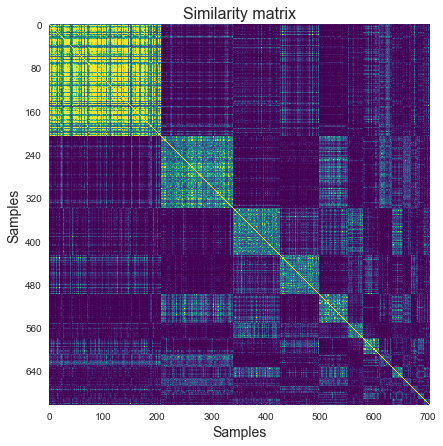

In [5934]:
sampleFrequencyMatrix = miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True) #0.333
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
miner.plotSimilarity(similarityMatrix,np.hstack(initialClasses),vmin=0,vmax=0.5,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"similarityMatrix_tmp.pdf"))

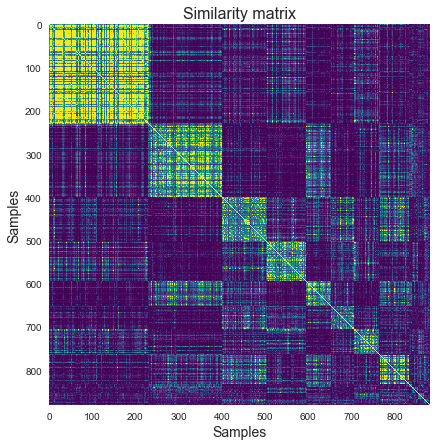

In [5935]:
centroidClusters, centroidMatrix = miner.centroids(initialClasses,sampleMatrix,f1Threshold = 0.1,returnCentroids=True) #0.3
centroidMatrix.to_csv(os.path.join(resultsDirectory,"centroids.csv"))
unmapped = list(sampleMatrix.columns[np.where(sampleMatrix.sum(axis=0)==0)[0]])
mappedSamples = [i for i in np.hstack(centroidClusters) if i not in unmapped]
miner.plotSimilarity(similarityMatrix,mappedSamples,vmin=0,vmax=0.333,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"centroidClusters_tmp.pdf"))

In [5936]:
mappedClusters = miner.mapExpressionToNetwork(centroidMatrix,sampleMatrix,threshold = 0.05) #0.25

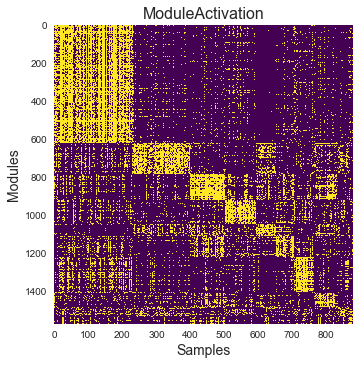

In [5937]:
reload(miner)
orderedOverExpressedMembers = miner.orderMembership(centroidMatrix,sampleMatrix,mappedClusters,ylabel="Modules",resultsDirectory=None)

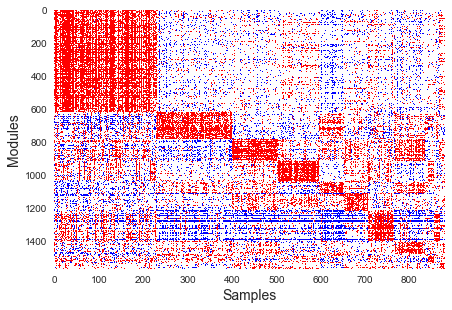

In [5938]:
reload(miner)
orderedDM = miner.plotDifferentialMatrix(overExpressedMembersMatrix,underExpressedMembersMatrix,orderedOverExpressedMembers,cmap="bwr",saveFile=os.path.join(resultsDirectory,"activity_tmp.pdf"))

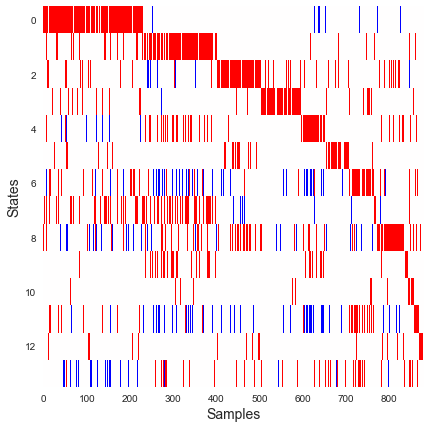

In [6009]:
reload(miner)
statesDf = miner.stateReduction(df=orderedDM,clusterList=centroidClusters,stateThreshold=0.7)
statesDf = statesDf.iloc[np.where(np.count_nonzero(statesDf,axis=1)>0)[0],:]
statesDf.to_csv(os.path.join(resultsDirectory,"states_standard_tmp.csv"))

fig = plt.figure(figsize=(7,7))
ax = fig.gca()
ax.imshow(statesDf.loc[:,orderedDM.columns],cmap="bwr",vmin=-1,vmax=1)
asp = statesDf.shape[1]/float(statesDf.shape[0])
ax.set_aspect(asp)
ax.grid(False)
ax.set_ylabel("States",FontSize=14)
ax.set_xlabel("Samples",FontSize=14)
plt.savefig(os.path.join(resultsDirectory,"states_tmp.pdf"),bbox_inches="tight")

In [6010]:
len(np.where(np.count_nonzero(statesDf,axis=0)==0)[0])/float(statesDf.shape[1])

0.04199772985244041

## Visualize sample subtypes with tSNE

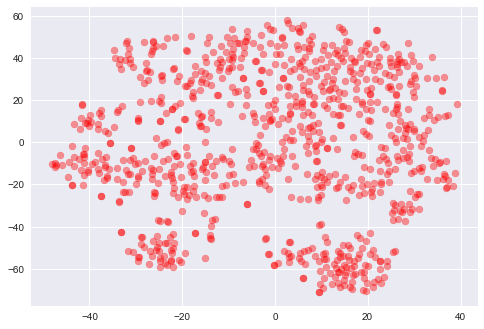

In [5535]:
# tSNE applied to expressionData. Set plotOnly = False to return tSNE coordinates
# consider changing the perplexity to explore different degrees of cluster separation
miner.tsne(expressionData,perplexity=15,n_components=2,n_iter=1000,plotOnly=True,plotColor="red",alpha=0.4)

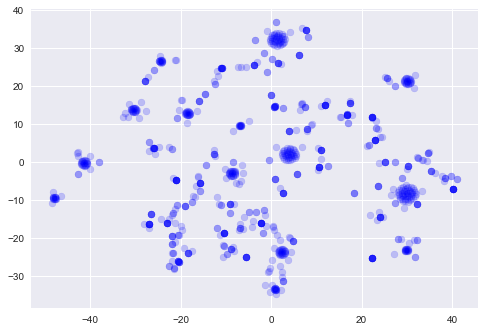

In [6011]:
# tSNE applied to orderedOverExpressedMembers. Consider changing the perplexity in the range of 5 to 50
X_embedded = miner.tsne(statesDf,perplexity=15,n_components=2,n_iter=500,plotOnly=None,plotColor="blue",alpha=0.2)
tsneDf = pd.DataFrame(X_embedded)
tsneDf.index = statesDf.columns
tsneDf.columns = ["tsne1","tsne2"]
#plt.savefig(os.path.join(resultsDirectory,"tsne_standard.pdf"),bbox_inches="tight")

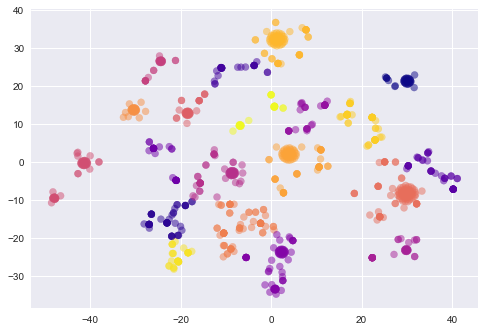

In [6016]:
# define subtypes by clustering tsne plot

# How many clusters do you expect?
numberOfClusters = 20

# Are the clusters separated how you thought? If not, change the random_state to a different number and retry
random_state=0

clusters, labels, centroids = miner.kmeans(tsneDf,numClusters=numberOfClusters,random_state=random_state)
plt.scatter(tsneDf.iloc[:,0],tsneDf.iloc[:,1],cmap="plasma",c=labels,alpha=0.5)
#plt.savefig(os.path.join(resultsDirectory,"labeled_tsne_standard.pdf"),bbox_inches="tight")

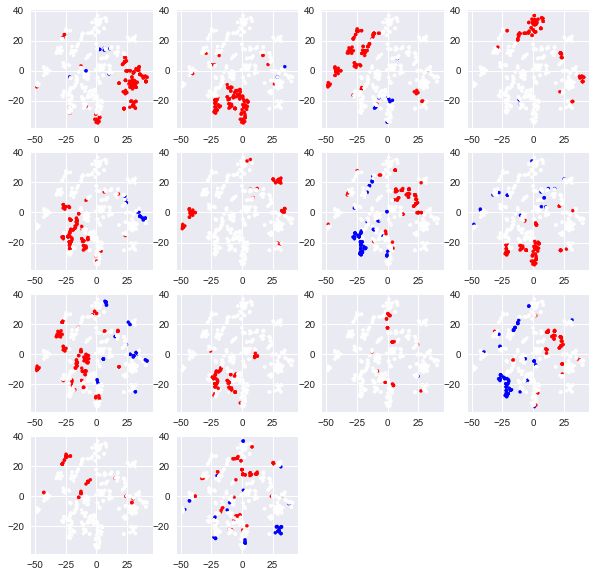

In [6019]:
#plot all states onto single stitched output
miner.plotStates(statesDf,tsneDf,numCols=4,saveFile = os.path.join(resultsDirectory,"states_o2.pdf"),size=10)

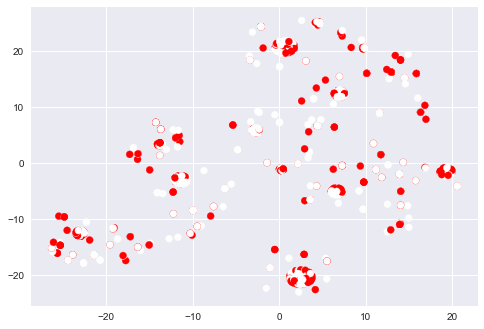

In [5873]:
# overlay single regulon activity onto tSNE
key_index = 10
moduleKey = referenceDictionary.keys()[key_index]
plt.scatter(X_embedded[:,0],X_embedded[:,1],cmap="bwr",c=np.array(sampleMatrix.loc[moduleKey,:]),vmin=-1,vmax=1)

# Next: Build predictor from state space df

# Warning: this will only run after survival analysis

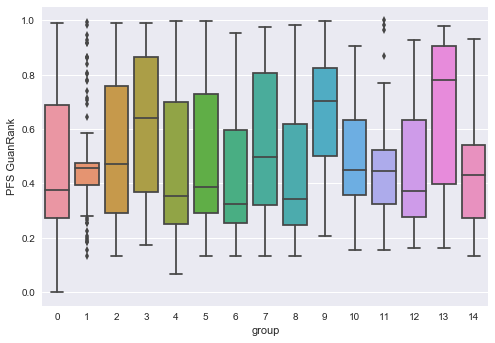

In [5995]:
srv = guanSurvivalDfMMRF.copy()
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(np.zeros(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)


groups = clusters
groups.sort(key = lambda s: -len(s))
labels = range(len(clusters))
for i in range(len(groups)):
    group = list(set(srv.index)&set(groups[i]))
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
    
import seaborn as sns
sns.boxplot(x='group', y='value', data=guan_srv_df,order=labels)
plt.ylabel("PFS GuanRank")
boxplotFilename = ("_").join([survival_tag,predictor_tag,"boxplot.pdf"])
#plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")

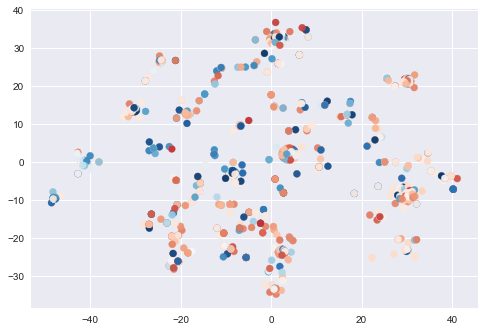

In [6022]:
# overlay sample subtypes ontp tSNE plot
gs = np.array(guanSurvivalDfMMRF.loc[:,"GuanScore"])
gs_index = np.array(guanSurvivalDfMMRF.index)

group = pd.DataFrame(np.median(gs)*np.ones(orderedOverExpressedMembers.shape[1]))
group.index = orderedOverExpressedMembers.columns
group.columns = ["GuanScore"]
group.loc[gs_index,"GuanScore"] = gs
group = np.array(group.iloc[:,0])

plt.scatter(X_embedded[:,0],X_embedded[:,1],cmap="RdBu",c=group,alpha=0.95)

In [5991]:
srv = survivalDfMMRF.copy()
cox_states = miner.parallelMemberSurvivalAnalysis(membershipDf = statesDf,numCores=1,survivalPath="",survivalData=srv)
print(cox_states)

10
{0: (-1.5236890850682487, 0.12758639733470734), 1: (-2.4154015223168166, 0.015717872143370632), 2: (3.3259847143599486, 0.0008810676022856745), 3: (0.33785877536188613, 0.7354696150974014), 4: (-1.3153532807604398, 0.1883911991943198), 5: (2.4641476580786525, 0.013733951968941217), 6: (1.8784213814122699, 0.06032354280364374), 7: (-1.9929827448771373, 0.04626333657924446), 8: (4.912764378354498, 8.980117164099994e-07), 9: (-0.5072897867303527, 0.6119515036897805), 10: (-0.5861181950180049, 0.557796089938541), 11: (2.207580747837569, 0.027273512416962763), 12: (0.5896974430171114, 0.5553935097979741), 13: (0.16118807007859098, 0.8719452769529625)}


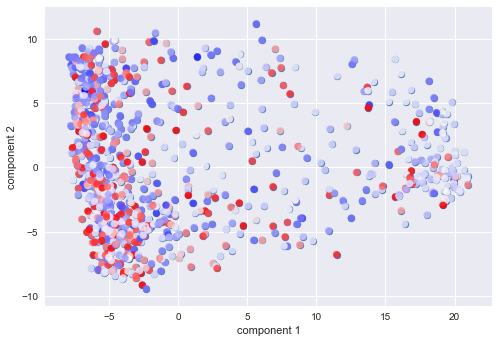

In [6003]:
pca1, pca2 = miner.plotPCA(orderedOverExpressedMembers)
plt.scatter(pca1,pca2,cmap="bwr",c=group,alpha=0.85)

# Cox survival based upon binary regulon membership

# Training dataset

In [5542]:
# load survival data
survivalMMRF = pd.read_csv(os.path.join("..","data","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
overExpressedMembersMatrixMMRF = overExpressedMembersMatrixMMRF.loc[orderedOverExpressedMembers.index,:]

# Validation datasets

## Process expression data

In [5543]:
# GSE24080UAMS
expressionDataGSE24080UAMS = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE24080UAMSentrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE24080UAMS, _ = miner.identifierConversion(expressionData=expressionDataGSE24080UAMS)
expressionDataGSE24080UAMS = miner.zscore(expressionDataGSE24080UAMS)
bkgdGSE24080UAMS = miner.backgroundDf(expressionDataGSE24080UAMS)
overExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(regulonModules,bkgdUAMS,label=2)
overExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(overExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)
overExpressedMembersMatrixGSE24080UAMS = overExpressedMembersMatrixGSE24080UAMS.loc[orderedOverExpressedMembers.index,:]

# GSE19784HOVON65 
expressionDataGSE19784HOVON65 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE19784HOVON65entrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE19784HOVON65, _ = miner.identifierConversion(expressionData=expressionDataGSE19784HOVON65)
expressionDataGSE19784HOVON65 = miner.zscore(expressionDataGSE19784HOVON65)
bkgdGSE19784HOVON65 = miner.backgroundDf(expressionDataGSE19784HOVON65)
overExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE19784HOVON65,label=2)
overExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(overExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)
overExpressedMembersMatrixGSE19784HOVON65 = overExpressedMembersMatrixGSE19784HOVON65.loc[orderedOverExpressedMembers.index,:]

# EMTAB4032
expressionDataEMTAB4032 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","EMTAB4032entrezIDlevel.csv"),index_col=0,header=0)
expressionDataEMTAB4032, _ = miner.identifierConversion(expressionData=expressionDataEMTAB4032)
expressionDataEMTAB4032 = miner.zscore(expressionDataEMTAB4032)
bkgdEMTAB4032 = miner.backgroundDf(expressionDataEMTAB4032)
overExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(regulonModules,bkgdEMTAB4032,label=2)
overExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEMTAB4032,expressionDataEMTAB4032)
overExpressedMembersMatrixEMTAB4032 = overExpressedMembersMatrixEMTAB4032.loc[orderedOverExpressedMembers.index,:]

completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
completed identifier conversion.
17228 genes were converted.
completed z-transformation.
done!


## Process survival data

In [5544]:
survival = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","globalClinTraining.csv"),index_col=0,header=0)

survivalGSE24080UAMS = survival[survival.index=='GSE24080UAMS']
survivalGSE24080UAMS.index = survivalGSE24080UAMS.iloc[:,0]
survivalGSE24080UAMS.head(3)
survivalDfGSE24080UAMS = survivalGSE24080UAMS.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE24080UAMS.columns = ["duration","observed"]

survivalGSE19784HOVON65 = survival[survival.index=='HOVON65']
survivalGSE19784HOVON65.index = survivalGSE19784HOVON65.iloc[:,0]
survivalGSE19784HOVON65.head(3)
survivalDfGSE19784HOVON65 = survivalGSE19784HOVON65.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE19784HOVON65.columns = ["duration","observed"]

survivalEMTAB4032 = survival[survival.index=='EMTAB4032']
survivalEMTAB4032.index = survivalEMTAB4032.iloc[:,0]
survivalEMTAB4032.head(3)
survivalDfEMTAB4032 = survivalEMTAB4032.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfEMTAB4032.columns = ["duration","observed"]

In [5545]:
#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfGSE24080UAMS,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfGSE24080UAMS = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfGSE19784HOVON65,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfGSE19784HOVON65 = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfEMTAB4032,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfEMTAB4032 = miner.guanRank(kmSurvival=kmDf)

In [5546]:
reload(miner)
Srvs = [guanSurvivalDfMMRF,guanSurvivalDfGSE24080UAMS]
Dfs = [overExpressedMembersMatrixMMRF,overExpressedMembersMatrixGSE24080UAMS]
pred_dict = miner.predictor(Dfs,Srvs,levels=50,numTrials=10,threshold=0.05,override=None,predictorFile = os.path.join(resultsDirectory,"predictor_dictionary_replicate.json"))

3.842174502160378e-24
['5848', '4775', '878', '1837', '5411', '2045', '3381', '3715', '2042', '4']
6.978108661288313e-09
['1784', '301', '4109', '3885', '848', '4347', '4835', '519', '4246', '1600']
3.088571072610624e-13
['5875', '2455', '2723', '92', '1040', '4970', '2593', '2519', '301', '35']
4.536037153526107e-09
['5042', '979', '2747', '2792', '2752', '1793', '3628', '907', '4616', '2470']
1.8836929271179867e-06
['2412', '2747', '4270', '551', '6425', '2831', '500', '3719', '53', '6264']
0.0003598483084183365
['4619', '5530', '2230', '5211', '2428', '1424', '2831', '1985', '3231', '5926']
5.303225337015523e-06
['5287', '2772', '5274', '3291', '4124']
6.916184466917823e-06
['4629', '4964', '1509', '465', '3200', '340', '46']
0.0005916868288061513
['2155']
7.820484617884339e-38
['3175', '1988', '2814', '354', '4418', '1035', '4263']
2.9151752516770165e-07
['4386', '1829', '323']
2.9806793446464217e-05
['90', '5941', '4332', '6357', '5486', '5740']
0.004307387860098149
['279', '4527'

In [5481]:
scoresDf

,t-score
MMRF_2754_1_BM,0.175002
MMRF_2151_1_BM,3.882214
MMRF_1634_1_BM,9.854795
MMRF_1450_1_BM,3.882214
MMRF_1778_1_BM,0.000000
MMRF_2115_1_BM,0.000000
MMRF_1851_1_BM,3.882214
MMRF_2272_1_BM,3.882214
MMRF_1270_1_BM,0.000000
MMRF_1598_1_BM,0.000000


In [5612]:
reload(miner)
df = overExpressedMembersMatrixEMTAB4032.copy()
srv = survivalDfEMTAB4032.copy()
scoresDf = miner.predictorScores(df,srv,pred_dict)
thresholdsMMRF = [5,2,0,-5] #miner.predictorThresholds(scoresDf)
pred_classes = miner.predictClasses(scoresDf,thresholdsMMRF)
survival_tag = "EMTAB4032"
predictor_tag = "mmrf;uams"
srv = guanSurvivalDfEMTAB4032.copy()
print(thresholdsMMRF)

[5, 2, 0, -5]


In [5613]:
vhr_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==5)[0]])
vlr_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==1)[0]])
hr_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==4)[0]])
lr_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==2)[0]])
avg_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==3)[0]])
total = float(len(vhr_)+len(hr_)+len(avg_)+len(lr_)+len(vlr_))
print(len(vhr_)/total,len(hr_)/total,len(avg_)/total,len(lr_)/total,len(vlr_)/total)

(0.10884353741496598, 0.1360544217687075, 0.23129251700680273, 0.14965986394557823, 0.3741496598639456)


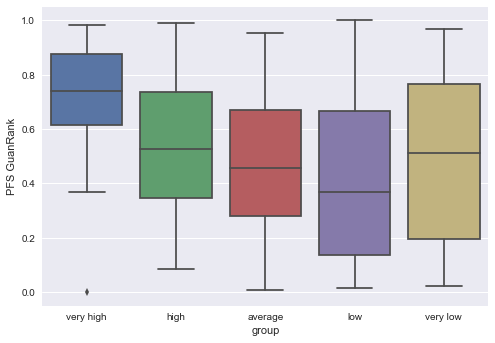

In [5614]:
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(np.zeros(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)


groups = [vhr_,hr_,avg_,lr_,vlr_]
labels = ["very high","high","average","low","very low"]
for i in range(len(groups)):
    group = groups[i]
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
    
import seaborn as sns
sns.boxplot(x='group', y='value', data=guan_srv_df,order=labels)
plt.ylabel("PFS GuanRank")
boxplotFilename = ("_").join([survival_tag,predictor_tag,"boxplot.pdf"])
plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")
#sns.stripplot(x='group', y='value', data=guan_srv_df,order=labels,color="orange", jitter=0.2, size=2.5)

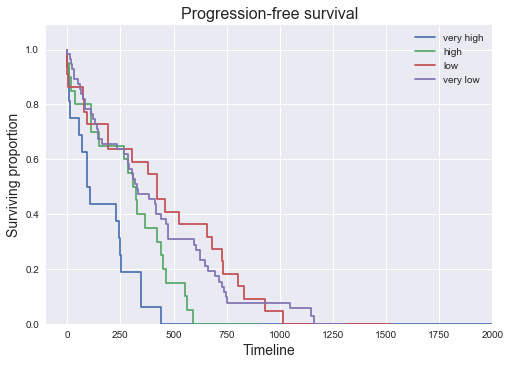

In [5615]:
reload(miner)
kmTag = "2000"
kmFilename = ("_").join([survival_tag,predictor_tag,kmTag,".pdf"])
groups = [vhr_,hr_,lr_,vlr_]
labels = ["very high","high","low","very low"]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,2000),filename=plotName)    

In [5616]:
groups = [vhr_,hr_,avg_,lr_,vlr_]
labels = ["very high","high","average","low","very low"]
cox_vectors = []
srv_set = set(srv.index)
for i in range(len(groups)):
    group = groups[i]
    patients = list(set(group)&srv_set)
    tmp_df = pd.DataFrame(np.zeros(srv.shape[0]))
    tmp_df.index = srv.index
    tmp_df.columns = [labels[i]]
    tmp_df.loc[patients,labels[i]] = 1
    cox_vectors.append(tmp_df)
    
pre_cox = pd.concat(cox_vectors,axis=1).T
pre_cox.head(5)
    
cox_dict = miner.parallelMemberSurvivalAnalysis(membershipDf = pre_cox,numCores=1,survivalPath="",survivalData=srv)
print(cox_dict)

/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['very high'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['high'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)
/Us

{'high': (1.269749350905666, 0.20417392749262686), 'very high': (1.8875215381843686, 0.05909021220608225), 'average': (-0.19634002612550783, 0.8443440347063036), 'low': (-1.2704608422528836, 0.20392052263481247), 'very low': (-0.5534058423516598, 0.579985539246644)}


# Generate inputs for causal analysis

In [3356]:
reload(miner)
miner.generateCausalInputs(expressionData,mechanisticOutput,coexpressionModules,saveFolder=resultsDirectory,regulon_dict=regulons,mutationFile="translocationsIA12.csv")    

# Pause to run NEO using the minerNEO notebook

# Continue to generate causal mechanistic network

In [3360]:
# After running NEO (in R), proceed with the following
preProcessedCausalResults = miner.processCausalResults(causalPath=os.path.join("..","results","causal"))
# load complete mutation matrix with default filters for use in postprocessing
filteredMutations = miner.mutationMatrix(mutationPath=os.path.join(os.path.expanduser("~"),"Desktop","miner","data"),mutationFiles = ["filteredMutationsIA12.csv","translocationsIA12.csv"],minNumMutations=None)
# load tf expression matrix for use in postprocessing
tfExp = miner.tfExpression(expressionData,motifPath=os.path.join("..","data","all_tfs_to_motifs.pkl"))
# load eigengenes matrix for use in postprocessing
eigengenes = pd.read_csv(os.path.join(os.path.expanduser("~"),"Desktop","miner","results","eigengenes.csv"),index_col=0,header=0)
# generate p values for all network edges for use in filtering
postProcessedCausalAnalysis = miner.postProcessCausalResults(preProcessedCausalResults,filteredMutations,tfExp,eigengenes,mechanisticOutput=None,numCores=5)
# write post-processed analysis to json file       
miner.write_json(postProcessedCausalAnalysis,os.path.join(os.path.expanduser("~"),"Desktop","miner","results","regulonNetworkPValues.json"))     
# generate causal mechanistic network in dataframe format
causalMechanisticNetwork = miner.causalMechanisticNetworkDictionary(postProcessedCausalAnalysis,biclusterRegulatorPvalue=0.05,regulatorMutationPvalue=0.05,mutationFrequency = 0.01,requireCausal=True)
# save causalMechanisticNetwork to csv
causalMechanisticNetwork.to_csv(os.path.join(os.path.expanduser("~"),"Desktop","miner","results","regulonCausalMechanisticNetwork.csv"))


0
0
0
0
10
0
10
10
20
20
30
10
10
20
30
30
20
40
40
50
30
60
50
70
40
20
60
80
70
50
90
60
80
40
100
70
90
110
80
100
120
30
110
90
130
50
100
120
140
40
110
120
60
130
130
150
140
140
150
160
160
50
150
170
170
70
160
180
170
190
180
60
180
200
80
210
190
190
220
200
230
70
200
210
240
90
210
220
220
250
230
230
260
100
80
240
250
110
240
270
260
90
270
280
120
250
290
280
130
260
140
300
270
150
280
310
290
100
320
290
160
300
330
300
340
350
310
170
310
320
110
320
180
330
330
340
360
340
190
370
350
200
380
120
350
390
360
400
210
370
410
360
220
380
420
370
230
430
390
400
380
240
130
410
250
440
260
390
450
420
460
270
400
470
140
480
430
410
280
420
440
490
430
500
450
510
290
460
150
440
450
470
300
460
480
160
470
520
490
480
500
510
490
310
520
500
530
530
510
540
170
520
550
530
540
550
540
560
550
570
320
180
560
560
580
570
330
590
580
340
570
190
600
590
350
610
600
620
360
580
610
630
370
200
620
640
380
590
630
650
210
390
600
660
640
400
650
660
610
410
620
420
430
220

In [3361]:
causalMechanisticNetwork.head(10)

,Cluster,Regulator,RegulatorToClusterEdge,RegulatorToClusterPValue,RegulatorBindingSiteEnrichment,Mutation,MutationToRegulatorEdge,MutationToRegulatorPValue,FrequencyOfMutation
0,0,ENSG00000112561,-1,8.254707075053736e-07,1e-10,ZNF727,-1,0.04962412309726247,0.0136208853575
5,1,ENSG00000134954,1,4.282516608765101e-06,1e-10,RNASeq_MAFA_Call,1,6.495343036587598e-06,0.0124858115778
8,1,ENSG00000112561,-1,9.928461308078495e-06,1e-10,ZNF727,-1,0.04962412309726247,0.0136208853575
10,1,ENSG00000150347,1,9.674711543824073e-11,1e-10,NRAS,-1,0.029861419714034828,0.208853575482
20,2,ENSG00000112561,-1,2.7987456080179917e-06,1e-10,ZNF727,-1,0.04962412309726247,0.0136208853575
24,2,ENSG00000100219,-1,1.3920579356328887e-07,1e-10,MXRA5,-1,0.013484330897574866,0.0261066969353
27,3,ENSG00000178951,1,3.3718431941610238e-06,1e-10,WDR90,-1,0.012968451588445538,0.0124858115778
29,4,ENSG00000185022,-1,8.922009465237698e-06,1e-10,KCNB1,1,0.029138535294976748,0.0147559591373
35,7,ENSG00000269404,1,4.186634953531434e-06,1e-10,MYC,1,0.00206736180456369,0.0147559591373
36,8,ENSG00000178951,-1,9.687395543799073e-06,1e-10,SVIL,-1,0.04844346756704692,0.0215664018161


# Investigate risk signatures

In [3294]:
reload(miner)                        
riskSignatures = miner.splitRiskSignatures(pred_dict,thresholds=thresholdsMMRF)               

In [3295]:
riskSignatures["very low"]

[['4561', '3897', '3883', '1887', '1979', '4560', '236'],
 ['3732', '3270', '4228', '5480', '5151', '1309', '4084', '34'],
 ['1314', '3382', '1965', '3350', '3544'],
 ['1611', '4993', '241'],
 ['3732', '5273', '5715', '6357', '5516', '1311', '2782', '243'],
 ['3786', '3330', '2821'],
 ['5699', '5870', '5862', '338'],
 ['1902', '3373', '4826', '6368', '5917'],
 ['1815', '3694', '1680'],
 ['1025', '1678', '323'],
 ['198', '2429']]

In [3296]:
veryLowBiclusters = np.hstack(riskSignatures["very low"])
print(veryLowBiclusters)

['4561' '3897' '3883' '1887' '1979' '4560' '236' '3732' '3270' '4228'
 '5480' '5151' '1309' '4084' '34' '1314' '3382' '1965' '3350' '3544'
 '1611' '4993' '241' '3732' '5273' '5715' '6357' '5516' '1311' '2782'
 '243' '3786' '3330' '2821' '5699' '5870' '5862' '338' '1902' '3373'
 '4826' '6368' '5917' '1815' '3694' '1680' '1025' '1678' '323' '198'
 '2429']


In [3307]:
vlr_genepool = np.array(np.hstack([regulonModules[key] for key in veryLowBiclusters]))
gene_count = Counter(vlr_genepool)
ranked_genes = gene_count.most_common()
core_genes = [g[0] for g in ranked_genes[100:200]]
np.savetxt(os.path.join(resultsDirectory,"core_genes.txt"),core_genes,fmt="%1.50s")

In [3311]:
lens = [len(regulonModules[key]) for key in veryLowBiclusters]
print(lens)

[347, 51, 92, 162, 185, 373, 472, 246, 118, 147, 156, 29, 116, 27, 119, 194, 221, 170, 129, 145, 126, 107, 315, 246, 128, 395, 222, 244, 350, 547, 306, 63, 89, 352, 38, 84, 76, 227, 72, 241, 333, 142, 147, 42, 132, 287, 105, 221, 88, 98, 84]


In [3319]:
core_genes = regulonModules['1680']
print(len(core_genes))
np.savetxt(os.path.join(resultsDirectory,"core_genes.txt"),core_genes,fmt="%1.50s")

287


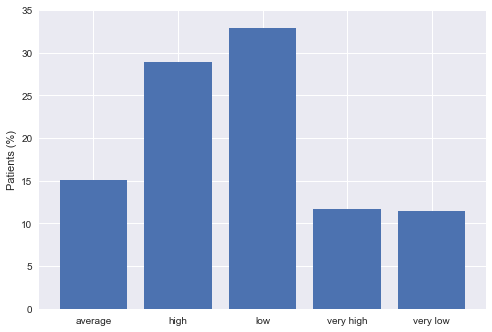

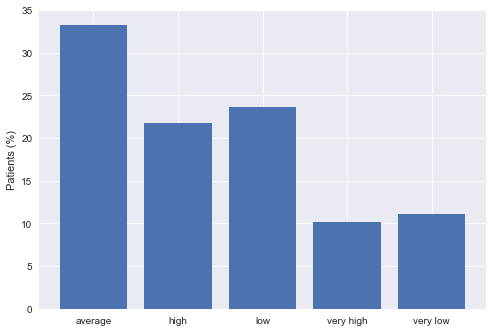

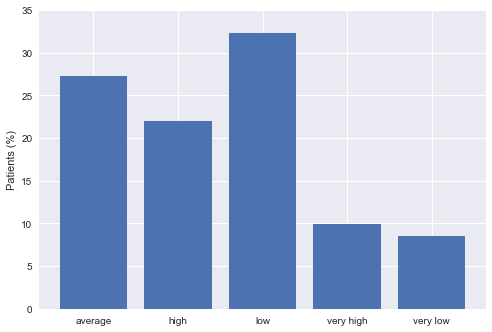

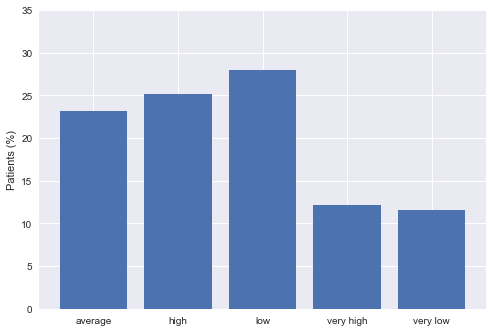

In [3331]:
#bar graph for proportions:
#labels = ["very high","high","average","low","very low"]
proportions_mmrf = [11.7,28.9,15.1,32.9,11.4]
proportions_uams = [10.2,21.8,33.2,23.6,11.1]
proportions_hovon = [9.9,22.0,27.3,32.3,8.5]
proportions_emtab = [12.2,25.2,23.1,27.9,11.6]

barFilename = "barplot"

plt.figure()
plt.bar(labels,proportions_mmrf)
plt.ylabel("Patients (%)")
ax = plt.gca()
ax.set_ylim(0,35)
plt.savefig(os.path.join(resultsDirectory,("_").join([barFilename,"mmrf.pdf"])),bbox_inches="tight")
plt.figure()
plt.bar(labels,proportions_uams)
plt.ylabel("Patients (%)")
ax = plt.gca()
ax.set_ylim(0,35)
plt.savefig(os.path.join(resultsDirectory,("_").join([barFilename,"uams.pdf"])),bbox_inches="tight")
plt.figure()
plt.bar(labels,proportions_hovon)
plt.ylabel("Patients (%)")
ax = plt.gca()
ax.set_ylim(0,35)
plt.savefig(os.path.join(resultsDirectory,("_").join([barFilename,"hovon65.pdf"])),bbox_inches="tight")
plt.figure()
plt.bar(labels,proportions_emtab)
plt.ylabel("Patients (%)")
ax = plt.gca()
ax.set_ylim(0,35)
plt.savefig(os.path.join(resultsDirectory,("_").join([barFilename,"emtab4032.pdf"])),bbox_inches="tight")

In [3341]:
print(len(vlr_))

62


In [3340]:
srv.loc[vlr_,:]

,duration,observed,kmEstimate,GuanScore
Patient,,,,
GSM592392,2954.433333,0,0.290829,0.144779
GSM592395,1301.333333,1,0.641463,0.643509
GSM592400,2824.300000,1,0.290829,0.291351
GSM592412,2827.350000,0,0.290829,0.144779
GSM592675,2594.533333,0,0.387773,0.193562
GSM592680,2407.466667,0,0.399523,0.199467
GSM592706,2534.550000,0,0.387773,0.193562
GSM592709,2509.133333,0,0.387773,0.193562
GSM592749,2311.900000,0,0.451636,0.225645


In [3386]:
np.array(causalMechanisticNetwork[causalMechanisticNetwork.Cluster=="1"].Regulator)

array(['ENSG00000134954', 'ENSG00000112561', 'ENSG00000150347'],
      dtype=object)

In [3413]:
vlr_biclusters = np.hstack(riskSignatures["very low"])
vlr_regulators = []
vlr_mutations = []
for bc in vlr_biclusters:
    vlr_regulators.extend(np.array(causalMechanisticNetwork[causalMechanisticNetwork.Cluster==bc].Regulator))
    vlr_mutations.extend(np.array(causalMechanisticNetwork[causalMechanisticNetwork.Cluster==bc].Mutation))    

In [3414]:
mutation_count = Counter(vlr_mutations)
mutation_rank = mutation_count.most_common()
regulator_count = Counter(vlr_regulators)
regulator_rank = regulator_count.most_common()

In [3416]:
mutation_rank
#regulator_rank

[('FAT3', 3),
 ('RNASeq_WHSC1_Call', 3),
 ('TACC2', 2),
 ('GPR158', 2),
 ('BRWD3', 2),
 ('PRKD2', 2),
 ('TRAF2', 1),
 ('HUWE1', 1),
 ('ZMYM6', 1),
 ('RNASeq_MAF_Call', 1),
 ('ZNF727', 1),
 ('TGDS', 1),
 ('MAX', 1),
 ('TNS3', 1),
 ('MXRA5', 1),
 ('ZNF462', 1),
 ('ZNF415', 1),
 ('KCNB1', 1)]

In [3423]:
vhr_

['MMRF_1634_1_BM',
 'MMRF_1450_1_BM',
 'MMRF_1778_1_BM',
 'MMRF_2272_1_BM',
 'MMRF_2739_1_BM',
 'MMRF_1540_1_BM',
 'MMRF_2300_1_BM',
 'MMRF_2401_1_BM',
 'MMRF_2490_1_BM',
 'MMRF_2251_1_BM',
 'MMRF_1107_1_BM',
 'MMRF_1910_1_BM',
 'MMRF_2557_1_BM',
 'MMRF_1890_1_BM',
 'MMRF_2290_1_BM',
 'MMRF_1668_1_BM',
 'MMRF_2722_1_BM',
 'MMRF_2562_1_BM',
 'MMRF_2621_1_BM',
 'MMRF_1912_1_PB',
 'MMRF_1587_1_BM',
 'MMRF_1361_1_BM',
 'MMRF_2781_1_BM',
 'MMRF_1897_1_BM',
 'MMRF_1082_1_BM',
 'MMRF_2455_1_BM',
 'MMRF_2089_1_BM',
 'MMRF_2106_1_BM',
 'MMRF_1790_1_BM',
 'MMRF_1432_1_BM',
 'MMRF_1252_1_BM',
 'MMRF_2720_1_BM',
 'MMRF_2039_1_BM',
 'MMRF_1496_1_BM',
 'MMRF_1335_1_BM',
 'MMRF_2535_1_BM',
 'MMRF_2172_1_BM',
 'MMRF_1320_1_BM',
 'MMRF_1415_1_BM',
 'MMRF_1501_1_BM',
 'MMRF_1815_1_BM',
 'MMRF_1974_1_BM',
 'MMRF_1491_1_BM',
 'MMRF_1289_1_BM',
 'MMRF_1656_1_BM',
 'MMRF_2394_1_BM',
 'MMRF_2531_1_BM',
 'MMRF_1490_1_BM',
 'MMRF_1771_1_BM',
 'MMRF_1531_1_BM',
 'MMRF_2015_1_BM',
 'MMRF_1542_1_BM',
 'MMRF_2225_

In [3431]:
riskSubtypeMutationFrequencies = {}
groups = [vhr_,hr_,avg_,lr_,vlr_]
labels = ["very high","high","average","low","very low"]
for i in range(len(groups)):
    group = groups[i]
    label = labels[i]
    riskSubtypeMutationFrequencies[label] = filteredMutations.loc[:,group].sum(axis=1)/float(len(group))

In [3461]:
differential_risk = riskSubtypeMutationFrequencies["very low"]-0.25*(riskSubtypeMutationFrequencies["very high"]+riskSubtypeMutationFrequencies["high"]+riskSubtypeMutationFrequencies["low"]+riskSubtypeMutationFrequencies["average"])

In [3462]:
differential_risk.sort_values()

RNASeq_FGFR3_Call   -0.064912
RNASeq_WHSC1_Call   -0.059355
LTB                 -0.042925
ZNF462              -0.038555
TP53                -0.038198
PKHD1               -0.037231
LRP1B               -0.036582
KRAS                -0.032801
EGR1                -0.031009
FREM2               -0.030669
LRP2                -0.029882
RYR2                -0.029790
CREBBP              -0.028308
SETD2               -0.027519
ZFHX3               -0.027328
DIS3                -0.027249
MUC16               -0.026769
CSMD1               -0.026270
GPR98               -0.026189
PKHD1L1             -0.025005
SVEP1               -0.022787
PCDH15              -0.022586
UNC13C              -0.021832
ZAN                 -0.021620
HMCN1               -0.021186
SPEF2               -0.020679
HIVEP1              -0.020657
BMP2K               -0.020396
SALL3               -0.020340
REV3L               -0.020023
                       ...   
RNF133               0.029862
AP3B2                0.030000
HIST1H1E  

In [3441]:
mut_freq = filteredMutations.sum(axis=1)/filteredMutations.shape[1]

In [3949]:
riskSubtypeMutationFrequencies["very low"]

KRAS                 0.215909
NRAS                 0.250000
TTN                  0.102273
DIS3                 0.079545
FAM46C               0.090909
MUC16                0.056818
TRAF3                0.090909
BRAF                 0.090909
PCLO                 0.045455
FAT3                 0.068182
CSMD3                0.068182
TP53                 0.011364
RYR2                 0.034091
LRP1B                0.022727
FAT4                 0.090909
FAT1                 0.090909
RYR1                 0.056818
FLG                  0.034091
FSIP2                0.034091
DNAH5                0.045455
USH2A                0.079545
EGR1                 0.011364
DUSP2                0.090909
HIST1H1E             0.068182
GPR98                0.011364
ATM                  0.011364
ZFHX4                0.045455
HMCN1                0.022727
SYNE1                0.056818
HUWE1                0.056818
                       ...   
SLC24A2              0.000000
HDAC4                0.000000
SEMA3C    

In [3955]:
vlr_t414 = filteredMutations.columns[np.where(filteredMutations.loc["RNASeq_WHSC1_Call",vlr_]==1)[0]]

In [3957]:
sumTest414 = filteredMutations.loc[:,vlr_t414].sum(axis=1)
sumTest414.sort_values()

TBC1D8      0.0
CDHR2       0.0
GNAQ        0.0
TRANK1      0.0
C3orf30     0.0
PTK2        0.0
KRT76       0.0
DAAM2       0.0
PHRF1       0.0
STRN        0.0
KIAA0556    0.0
SLC44A5     0.0
FHOD3       0.0
ZFP36L2     0.0
PIKFYVE     0.0
ARHGAP28    0.0
CCDC171     0.0
SLCO1B7     0.0
CDK8        0.0
RNF133      0.0
ZSCAN1      0.0
NPTX2       0.0
DLGAP1      0.0
GGA2        0.0
MICAL3      0.0
SAFB        0.0
APP         0.0
TRIM41      0.0
TRIM42      0.0
HTR2C       0.0
           ... 
CACNA1E     1.0
NDST4       1.0
MFHAS1      1.0
EEF1A1      1.0
CACNB2      1.0
DSCAM       1.0
DDX60       1.0
SP3         1.0
PTPN13      1.0
KIAA1598    1.0
ANXA1       1.0
PPP1R21     1.0
ANKRD11     1.0
CARD11      1.0
TMC1        1.0
OGT         1.0
SASH1       1.0
RIMS2       1.0
NRP2        1.0
ASCC3       1.0
KMT2C       1.0
ITGAV       1.0
LAMA3       1.0
LAMA5       1.0
MYH2        1.0
KLHL6       1.0
MTMR2       1.0
KRAS        1.0
MUC16       2.0
TTN         2.0
Length: 1746, dtype: flo

In [3958]:
filteredMutations.loc["RNASeq_WHSC1_Call",vlr_t414]

MMRF_1029_1_BM    0.0
MMRF_1030_1_BM    0.0
MMRF_1085_3_BM    0.0
MMRF_1128_1_BM    0.0
MMRF_1130_1_BM    0.0
MMRF_1137_1_BM    0.0
MMRF_1184_1_BM    0.0
MMRF_1229_1_BM    0.0
MMRF_1229_2_BM    0.0
Name: RNASeq_WHSC1_Call, dtype: float64